In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
#import torch.autograd as autograd
import torch.optim as optim

from datetime import datetime
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
from scipy.spatial.distance import pdist
from tqdm.notebook import tqdm, trange

from datafold.dynfold import (
    DiffusionMaps,
    GeometricHarmonicsInterpolator as GeometricHarmonics,
    LocalRegressionSelection
)
from datafold.pcfold import GaussianKernel
from subsample import subsample

In [2]:
plt.rc("axes",
    axisbelow = True,
    labelsize = 18, # axis label font size
    titlesize = 20 # title font size
)
plt.rc("font", family = "serif") # "sans-serif"
plt.rc("image", cmap = "viridis") # "cividis", "plasma", "Reds", "Greens", "Greys", "PuOr", "coolwarm"
plt.rc("legend",
    edgecolor = "k",
    fontsize = 15,
    framealpha = 1.0
)
plt.rc("text", usetex = True)
plt.rc("text.latex", preamble = r"\usepackage{bm}")
plt.rc("xtick", labelsize = 12) # axis tick mark font size
plt.rc("ytick", labelsize = 12) # axis tick mark font size

In [3]:
def tensor2array(t):
    return t.detach().cpu().numpy()

torch.set_default_dtype(torch.float64)
generator = np.random.default_rng(220523)

In [4]:
start_time = datetime.now()
print(start_time)

2022-05-24 11:34:35.094559


In [5]:
base_inputs = np.ones(4)
(q10, q12, q20, q21) = tuple(range(base_inputs.size))

(tmin, tmax) = (0.0, 5.0)
times = np.linspace(tmin, tmax, 101)
ic = [1.0, 0.0]

step = 10
N = times[step::step].size

input_names = [
    r"$\theta_{10}$",
    r"$\theta_{12}$",
    r"$\theta_{20}$",
    r"$\theta_{21}$"
]

In [6]:
def state_space_model(t, x, q_10, q_12, q_20, q_21):
    A = np.array(
        [[-(q_10 + q_12), q_21],
         [q_12, -(q_20 + q_21)]]
    )
    
    return np.matmul(A, x)

In [7]:
def system(p, verbose = False, use_both = False):
    p = np.array(p)
    if p.ndim < 2:
        p = np.reshape(p, (1, -1))
    elif p.ndim > 2:
        raise ValueError("Provide parameters as a matrix.")
    
    trajectories = np.zeros((p.shape[0], (use_both + 1)*N))
    for i in trange(p.shape[0]) if verbose else range(p.shape[0]):
        result = solve_ivp(
            fun = state_space_model, 
            t_span = (tmin, tmax),
            y0 = ic,
            args = tuple(p[i]),
            t_eval = times
        )
        
        if use_both:
            trajectories[i] = result.y[:,step::step].flatten()
        else:
            trajectories[i] = result.y[0,step::step]
    
    return trajectories

In [8]:
result = solve_ivp(
    fun = state_space_model, 
    t_span = (tmin, tmax),
    y0 = ic,
    args = tuple(base_inputs),
    t_eval = times
)

t = result.t
y = result.y
base_outputs = y[0,step::step]

In [9]:
def objective(p):
    return np.sum(
        (system(p) - base_outputs)**2.0
    )

# Minimize Output Distance to Find Level Set

In [10]:
column_names = ["q10", "q12", "q20", "q21"] + \
               ["y%d" % (i+1,) for i in range(base_outputs.size)]

try:
    df = pd.read_excel("Base-Matching.xlsx")
    
    minimizers = df.values[:,:4]
    minimizer_outputs = df.values[:,4:]
except:
    minimizers = np.zeros((5000, base_inputs.size))
    minimizer_outputs = np.zeros((minimizers.shape[0], base_outputs.size))

    for i in trange(minimizers.shape[0]):
        p = generator.uniform(low = 0.75, high = 1.25, size = base_inputs.shape)
        result = minimize(
            objective,
            x0 = p,
            method = "BFGS",
            options = {
                "gtol": 1e-8
            }
        )
        if not result.success:
            print(i, result.message)
        minimizers[i] = result.x
        minimizer_outputs[i] = system(result.x)

    df = pd.DataFrame(
        data = np.c_[
            minimizers,
            minimizer_outputs
        ], columns = column_names
    )
    df.to_excel("Base-Matching.xlsx", index = False)

# Load and Predict Redundant Parameter with CAE

In [11]:
class FeedForward(torch.nn.Module):
    def __init__(self, inp = 2, outp = 2):
        super(FeedForward, self).__init__()
        self.fc1 = torch.nn.Linear(inp, 20) # fully connected layers
        self.fc2 = torch.nn.Linear(20, 20)
        self.fc3 = torch.nn.Linear(20, 20)
        self.fc4 = torch.nn.Linear(20, 20)
        self.fc5 = torch.nn.Linear(20, outp)

    def forward(self, x):
        if x.requires_grad == False:
            x.requires_grad = True  # Keep track of gradient wrt input.

        y = torch.tanh(self.fc1(x))
        y = torch.tanh(self.fc2(y))
        y = torch.tanh(self.fc3(y))
        y = torch.tanh(self.fc4(y))
        y = (self.fc5(y))

        return y

In [12]:
model_dict = torch.load("Models/220521d_CAE.pt")

encoder = FeedForward(inp = 4, outp = 4)
encoder.load_state_dict(model_dict["encoder_state_dict"])
encoding_optimizer = optim.Adam(encoder.parameters(), lr = 0.01)
encoding_optimizer.load_state_dict(model_dict["encoding_optimizer_state_dict"])
encoder.eval()

decoder = FeedForward(inp = 4, outp = 4)
decoder.load_state_dict(model_dict["decoder_state_dict"])
decoding_optimizer = optim.Adam(decoder.parameters(), lr = 0.01)
decoding_optimizer.load_state_dict(model_dict["decoding_optimizer_state_dict"])
decoder.eval()

predictor = FeedForward(inp = 3, outp = 10)
predictor.load_state_dict(model_dict["predictor_state_dict"])
prediction_optimizer = optim.Adam(predictor.parameters(), lr = 0.01)
prediction_optimizer.load_state_dict(model_dict["prediction_optimizer_state_dict"])
predictor.eval()

conformal_coordinates = tensor2array(encoder(torch.from_numpy(minimizers)))

# Diffusion Maps

In [13]:
eps = np.median(pdist(minimizers, metric = "sqeuclidean"))
print("Using epsilon = %.8f" % (eps,))

dmap = DiffusionMaps(
    kernel = GaussianKernel(epsilon = eps),
    n_eigenpairs = 16,
    dist_kwargs = dict(cut_off = np.inf),
    alpha = 1.0
).fit(minimizers)

(evecs, evals) = (dmap.eigenvectors_.T, dmap.eigenvalues_)

Using epsilon = 0.01943746


In [14]:
selection = LocalRegressionSelection(
    intrinsic_dim = 1,
    n_subsample = 500,
    random_state = 1216,
    strategy = "dim"
).fit(dmap.eigenvectors_)
idx = selection.evec_indices_
phi = evecs[idx].T

print("Parsim. Eigenvectors:", idx)
for i in range(evals.size):
    print("%2d  %10.8f  %7.5f" % (i, evals[i], selection.residuals_[i]))

Parsim. Eigenvectors: [1]
 0  1.00000000      nan
 1  0.67631940  1.00000
 2  0.40173156  0.10314
 3  0.20403883  0.05526
 4  0.09191872  0.06126
 5  0.03735716  0.06737
 6  0.01388005  0.07489
 7  0.00469647  0.06736
 8  0.00140988  0.05318
 9  0.00038400  0.04228
10  0.00009601  0.05706
11  0.00002192  0.05479
12  0.00000468  0.03748
13  0.00000088  0.03557
14  0.00000015  0.05809
15  0.00000002  0.05121


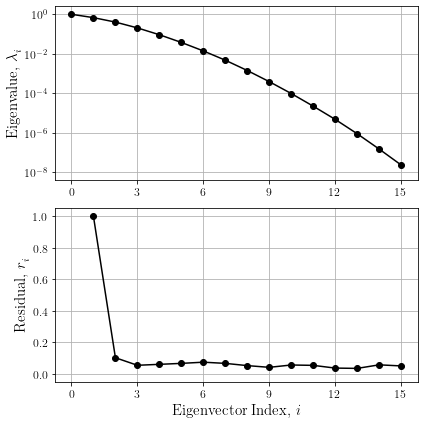

In [15]:
fig_01 = plt.figure(figsize = (6, 6))
ax11 = fig_01.add_subplot(211)
ax11.semilogy(evals, "ko-")
ax11.set_ylim((10**-8.4, 10.0**0.4))
ax11.set_xticks(np.linspace(0, 15, 6))
ax11.set_yticks(np.logspace(-8.0, 0.0, 5))
ax11.set_ylabel(r"Eigenvalue, $\lambda_i^{}$", fontsize = 15)
ax11.grid(True)
ax12 = fig_01.add_subplot(212)
ax12.plot(np.arange(1, selection.residuals_.size), selection.residuals_[1:], "ko-")
ax12.set_xticks(np.linspace(0, 15, 6))
ax12.set_xlabel(r"Eigenvector Index, $i$", fontsize = 15)
ax12.set_ylabel(r"Residual, $r_i^{}$", fontsize = 15)
ax12.set_xlim(ax11.get_xlim())
ax12.set_ylim((-0.05, 1.05))
ax12.grid(True)
plt.tight_layout()
#fig_01.savefig("Figures/Residuals_for_Redundant.pdf", bbox_inches = "tight")

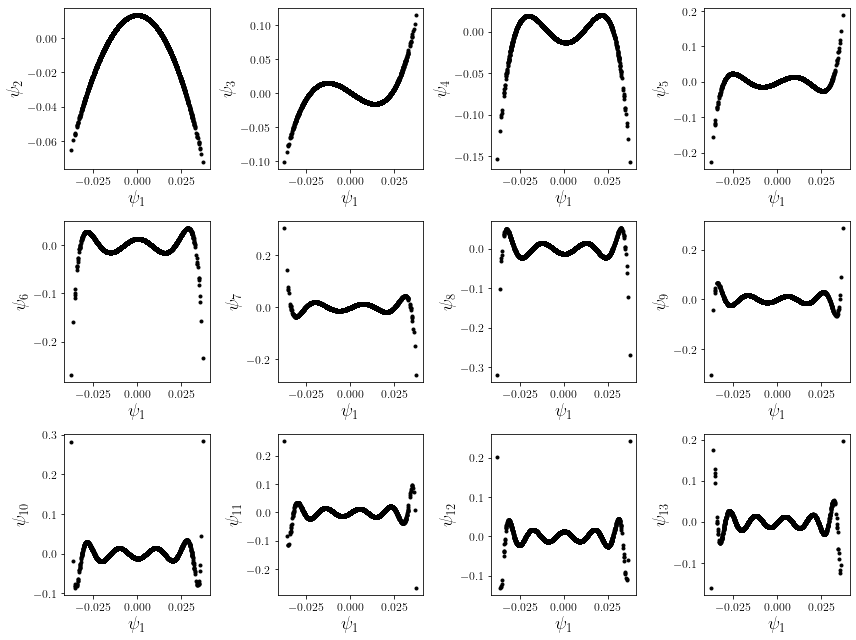

In [16]:
num_rows = 3
num_cols = 4

fig_02 = plt.figure(figsize = (3*num_cols, 3*num_rows));
for i in range (2, num_rows*num_cols + 2):
    fmt = "r." if i in idx else "k."
    ax = fig_02.add_subplot(num_rows, num_cols, i-1)
    ax.plot(evecs[1], evecs[i], fmt)
    ax.set_xlabel(r"$\psi_1$")
    ax.set_ylabel(r"$\psi_{%d}$" % i)
    ax.grid(False)
plt.tight_layout()

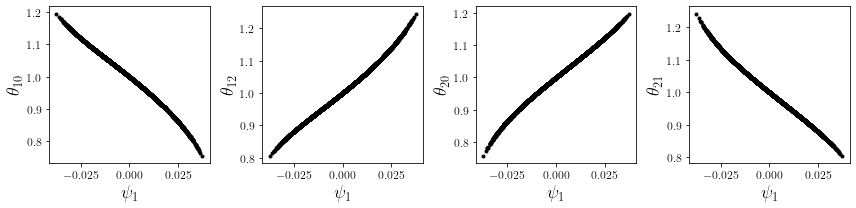

In [17]:
fig_03 = plt.figure(figsize = (12, 3));
for i in range(minimizers.shape[1]):
    ax = fig_03.add_subplot(141 + i)
    ax.plot(evecs[1], minimizers[:,i], "k.")
    ax.set_xlabel(r"$\psi_1$")
    ax.set_ylabel(input_names[i])
    ax.grid(False)
plt.tight_layout()

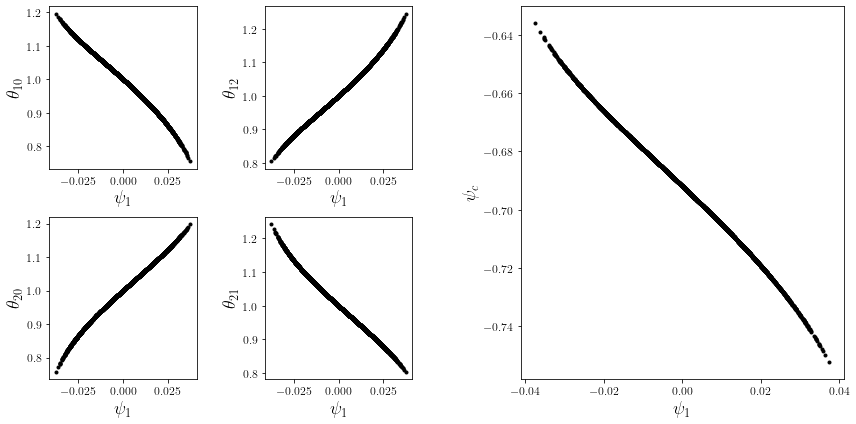

In [23]:
fig_03a = plt.figure(figsize = (12, 6))
for (i, loc) in enumerate([1, 2, 5, 6]):
    ax = fig_03a.add_subplot(2, 4, loc)
    ax.plot(evecs[1], minimizers[:,i], "k.")
    ax.set_xlabel(r"$\psi_1$")
    ax.set_ylabel(input_names[i])
    ax.grid(False)
ax = fig_03a.add_subplot(122)
ax.plot(evecs[1], conformal_coordinates[:,-1], "k.")
ax.set_xlabel(r"$\psi_1$")
ax.set_ylabel(r"$\psi_c$")
ax.grid(False)
plt.tight_layout()

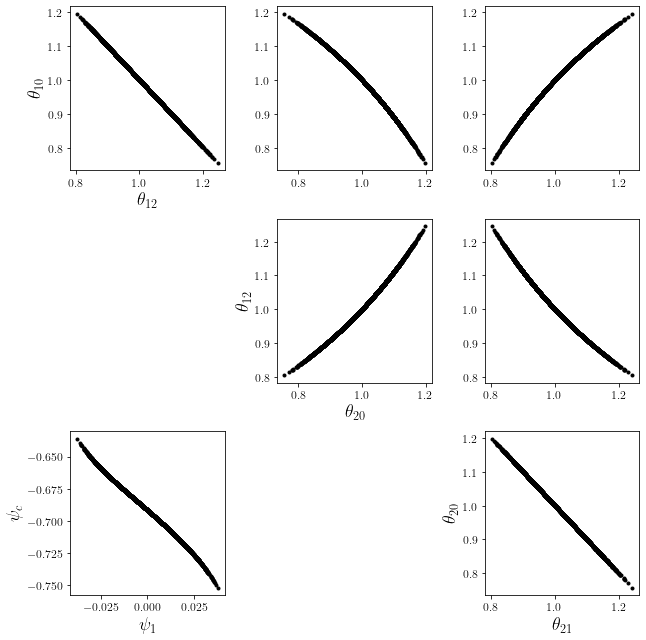

In [22]:
fig_04 = plt.figure(figsize = (9, 9))
for i in range(3):
    for j in range(i, 3):
        ax = fig_04.add_subplot(3, 3, 3*i + j + 1)
        ax.plot(minimizers[:,j+1], minimizers[:,i], "k.")
        if i == j:
            ax.set_xlabel(input_names[j+1])
            ax.set_ylabel(input_names[i])
        ax.grid(False)

ax = fig_04.add_subplot(337)
ax.plot(evecs[1], conformal_coordinates[:,-1], "k.")
ax.set_xlabel(r"$\psi_1$")
ax.set_ylabel(r"$\psi_c$")
ax.grid(False)
plt.tight_layout()

In [19]:
end_time = datetime.now()
print(end_time)
print(end_time - start_time)

2022-05-24 11:35:06.040466
0:00:30.945907


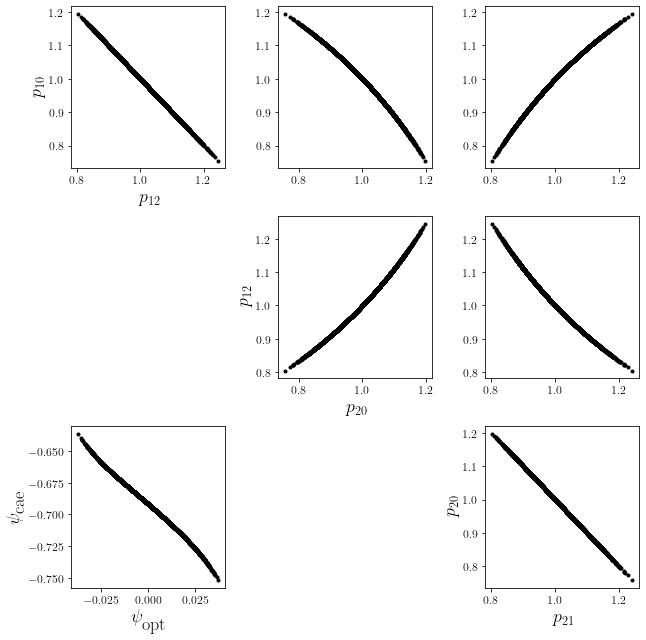

In [20]:
pnames = [
    r"$p_{10}$",
    r"$p_{12}$",
    r"$p_{20}$",
    r"$p_{21}$"
]

fig_04p = plt.figure(figsize = (9, 9))
for i in range(3):
    for j in range(i, 3):
        ax = fig_04p.add_subplot(3, 3, 3*i + j + 1)
        ax.plot(minimizers[:,j+1], minimizers[:,i], "k.")
        if i == j:
            ax.set_xlabel(pnames[j+1])
            ax.set_ylabel(pnames[i])
        ax.grid(False)

ax = fig_04p.add_subplot(337)
ax.plot(evecs[1], conformal_coordinates[:,-1], "k.")
ax.set_xlabel(r"$\psi_{\textrm{opt}}^{}$")
ax.set_ylabel(r"$\psi_{\textrm{cae}}^{}$")
ax.grid(False)
plt.tight_layout()

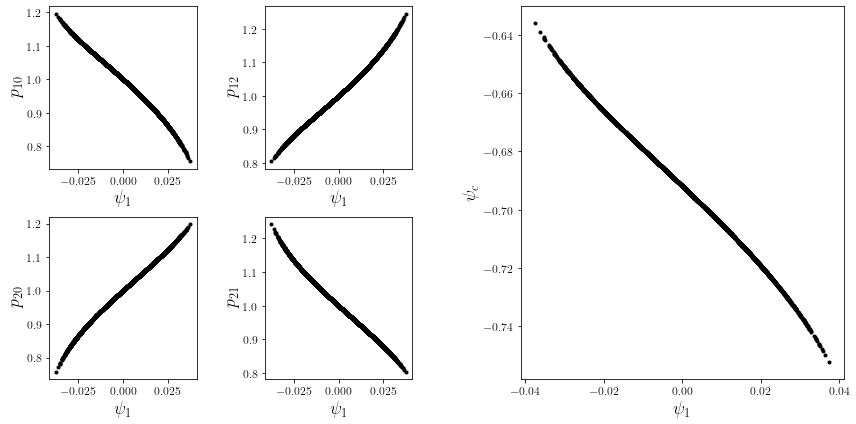

In [24]:
fig_03ap = plt.figure(figsize = (12, 6))
for (i, loc) in enumerate([1, 2, 5, 6]):
    ax = fig_03ap.add_subplot(2, 4, loc)
    ax.plot(evecs[1], minimizers[:,i], "k.")
    ax.set_xlabel(r"$\psi_1$")
    ax.set_ylabel(pnames[i])
    ax.grid(False)
ax = fig_03ap.add_subplot(122)
ax.plot(evecs[1], conformal_coordinates[:,-1], "k.")
ax.set_xlabel(r"$\psi_1$")
ax.set_ylabel(r"$\psi_c$")
ax.grid(False)
plt.tight_layout()

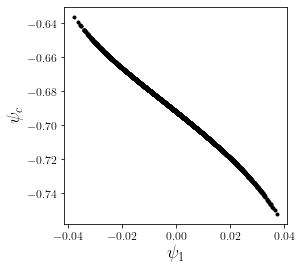

In [26]:
fig = plt.figure(figsize = (4, 4))
ax = fig.add_subplot(111)
ax.plot(evecs[1], conformal_coordinates[:,-1], "k.")
ax.set_xlabel(r"$\psi_1$")
ax.set_ylabel(r"$\psi_c$")
ax.grid(False)
fig.savefig("Figures/Conformal_vs_DMaps.pdf", bbox_inches = "tight")